### Importing Libraries

In [117]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
import string
import re
pd.set_option('Display.max_colwidth',None)
import warnings
warnings.filterwarnings("ignore")

In [12]:
df= pd.read_excel('Service_now.xlsx',engine='openpyxl')

In [13]:
df.head()

,Short description,Description,Team
0,login issue,unable to login.Kindly reset the password,Windows Team
1,account locked out,Windows Account locked out. Kindly unlock my account,Windows Team
2,activate iphone,Kindly activate my login in my new iphone,Windows Team
3,login issue,unable to login.Kindly reset the password,Windows Team
4,"laptop is very slow, any dialog bog i open is choppy & flickers.... delayed","laptop is very slow, kindly resolve the issue",Laptop technician team


In [14]:
df.describe()

,Short description,Description,Team
count,314,315,314
unique,222,95,10
top,login issue,unable to login.Kindly reset the password,Windows Team
freq,18,23,106


### Text Preprocessing

##### Check for null values

In [6]:
df.isnull().sum()


Short description    3
Description          2
Team                 3
dtype: int64

In [15]:
df.dropna(inplace=True)
df.isnull().sum()

Short description    0
Description          0
Team                 0
dtype: int64

In [16]:
df.shape

(314, 3)

In [9]:
df.drop_duplicates(inplace=True)
df.shape

(257, 3)

In [17]:
df=df[['Description','Team']]
df.head(3)

,Description,Team
0,unable to login.Kindly reset the password,Windows Team
1,Windows Account locked out. Kindly unlock my account,Windows Team
2,Kindly activate my login in my new iphone,Windows Team


#### Preprocessing Steps

In [18]:
def get_wordnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def preprocessing(sentence):
    sentence=sentence.lower()
    sentence= re.sub('[^\w]',' ',sentence)
    sentence=word_tokenize(sentence)
    punc=string.punctuation
    sentence=[word for word in sentence if word not in punc]
    stopwords_set = set(stopwords.words('english'))
    stopwords_filtered = [word for word in stopwords_set if word not in ["not","no","nor","don't","aren't","couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't","isn't","mightn't","mustn't",  "needn't","shouldn't","wasn't","weren't","won't","wouldn't"]]
    sentence= [word for word in sentence if word not in stopwords_filtered]
    postag= nltk.tag.pos_tag(sentence)
    wordnet_tagged=map(lambda x:(x[0],get_wordnet_tag(x[1])),postag)
    lemmatized_sentence=[]
    for word,tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word,tag))
    sentence= ' '.join (lemmatized_sentence)
    return sentence

    
    
    

In [19]:
lemmatizer=WordNetLemmatizer()
processed_collection = []
for each_description in df['Description']:
    processed_description = preprocessing(each_description)
    processed_collection.append(processed_description)

df['processed_description'] = processed_collection
df.head()

,Description,Team,processed_description
0,unable to login.Kindly reset the password,Windows Team,unable login kindly reset password
1,Windows Account locked out. Kindly unlock my account,Windows Team,window account lock kindly unlock account
2,Kindly activate my login in my new iphone,Windows Team,kindly activate login new iphone
3,unable to login.Kindly reset the password,Windows Team,unable login kindly reset password
4,"laptop is very slow, kindly resolve the issue",Laptop technician team,laptop slow kindly resolve issue


In [20]:
df=df[['processed_description','Team']]
df.head()

,processed_description,Team
0,unable login kindly reset password,Windows Team
1,window account lock kindly unlock account,Windows Team
2,kindly activate login new iphone,Windows Team
3,unable login kindly reset password,Windows Team
4,laptop slow kindly resolve issue,Laptop technician team


In [21]:
df['processed_description']  = df['processed_description'].astype(str)
df['Target']=df['Team']
df.drop('Team',axis=1,inplace=True)

#### Visualizing based on group

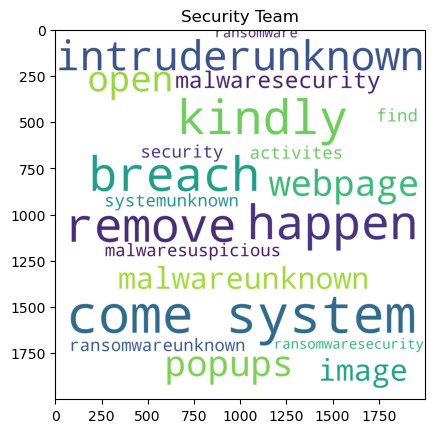

In [14]:
from wordcloud import WordCloud
wc=WordCloud(width=2000,height=2000,background_color='white')
wc = wc.generate(df[df['Target']=='Security Team']['processed_description'].str.cat(sep=''))
plt.title('Security Team')
plt.imshow(wc)



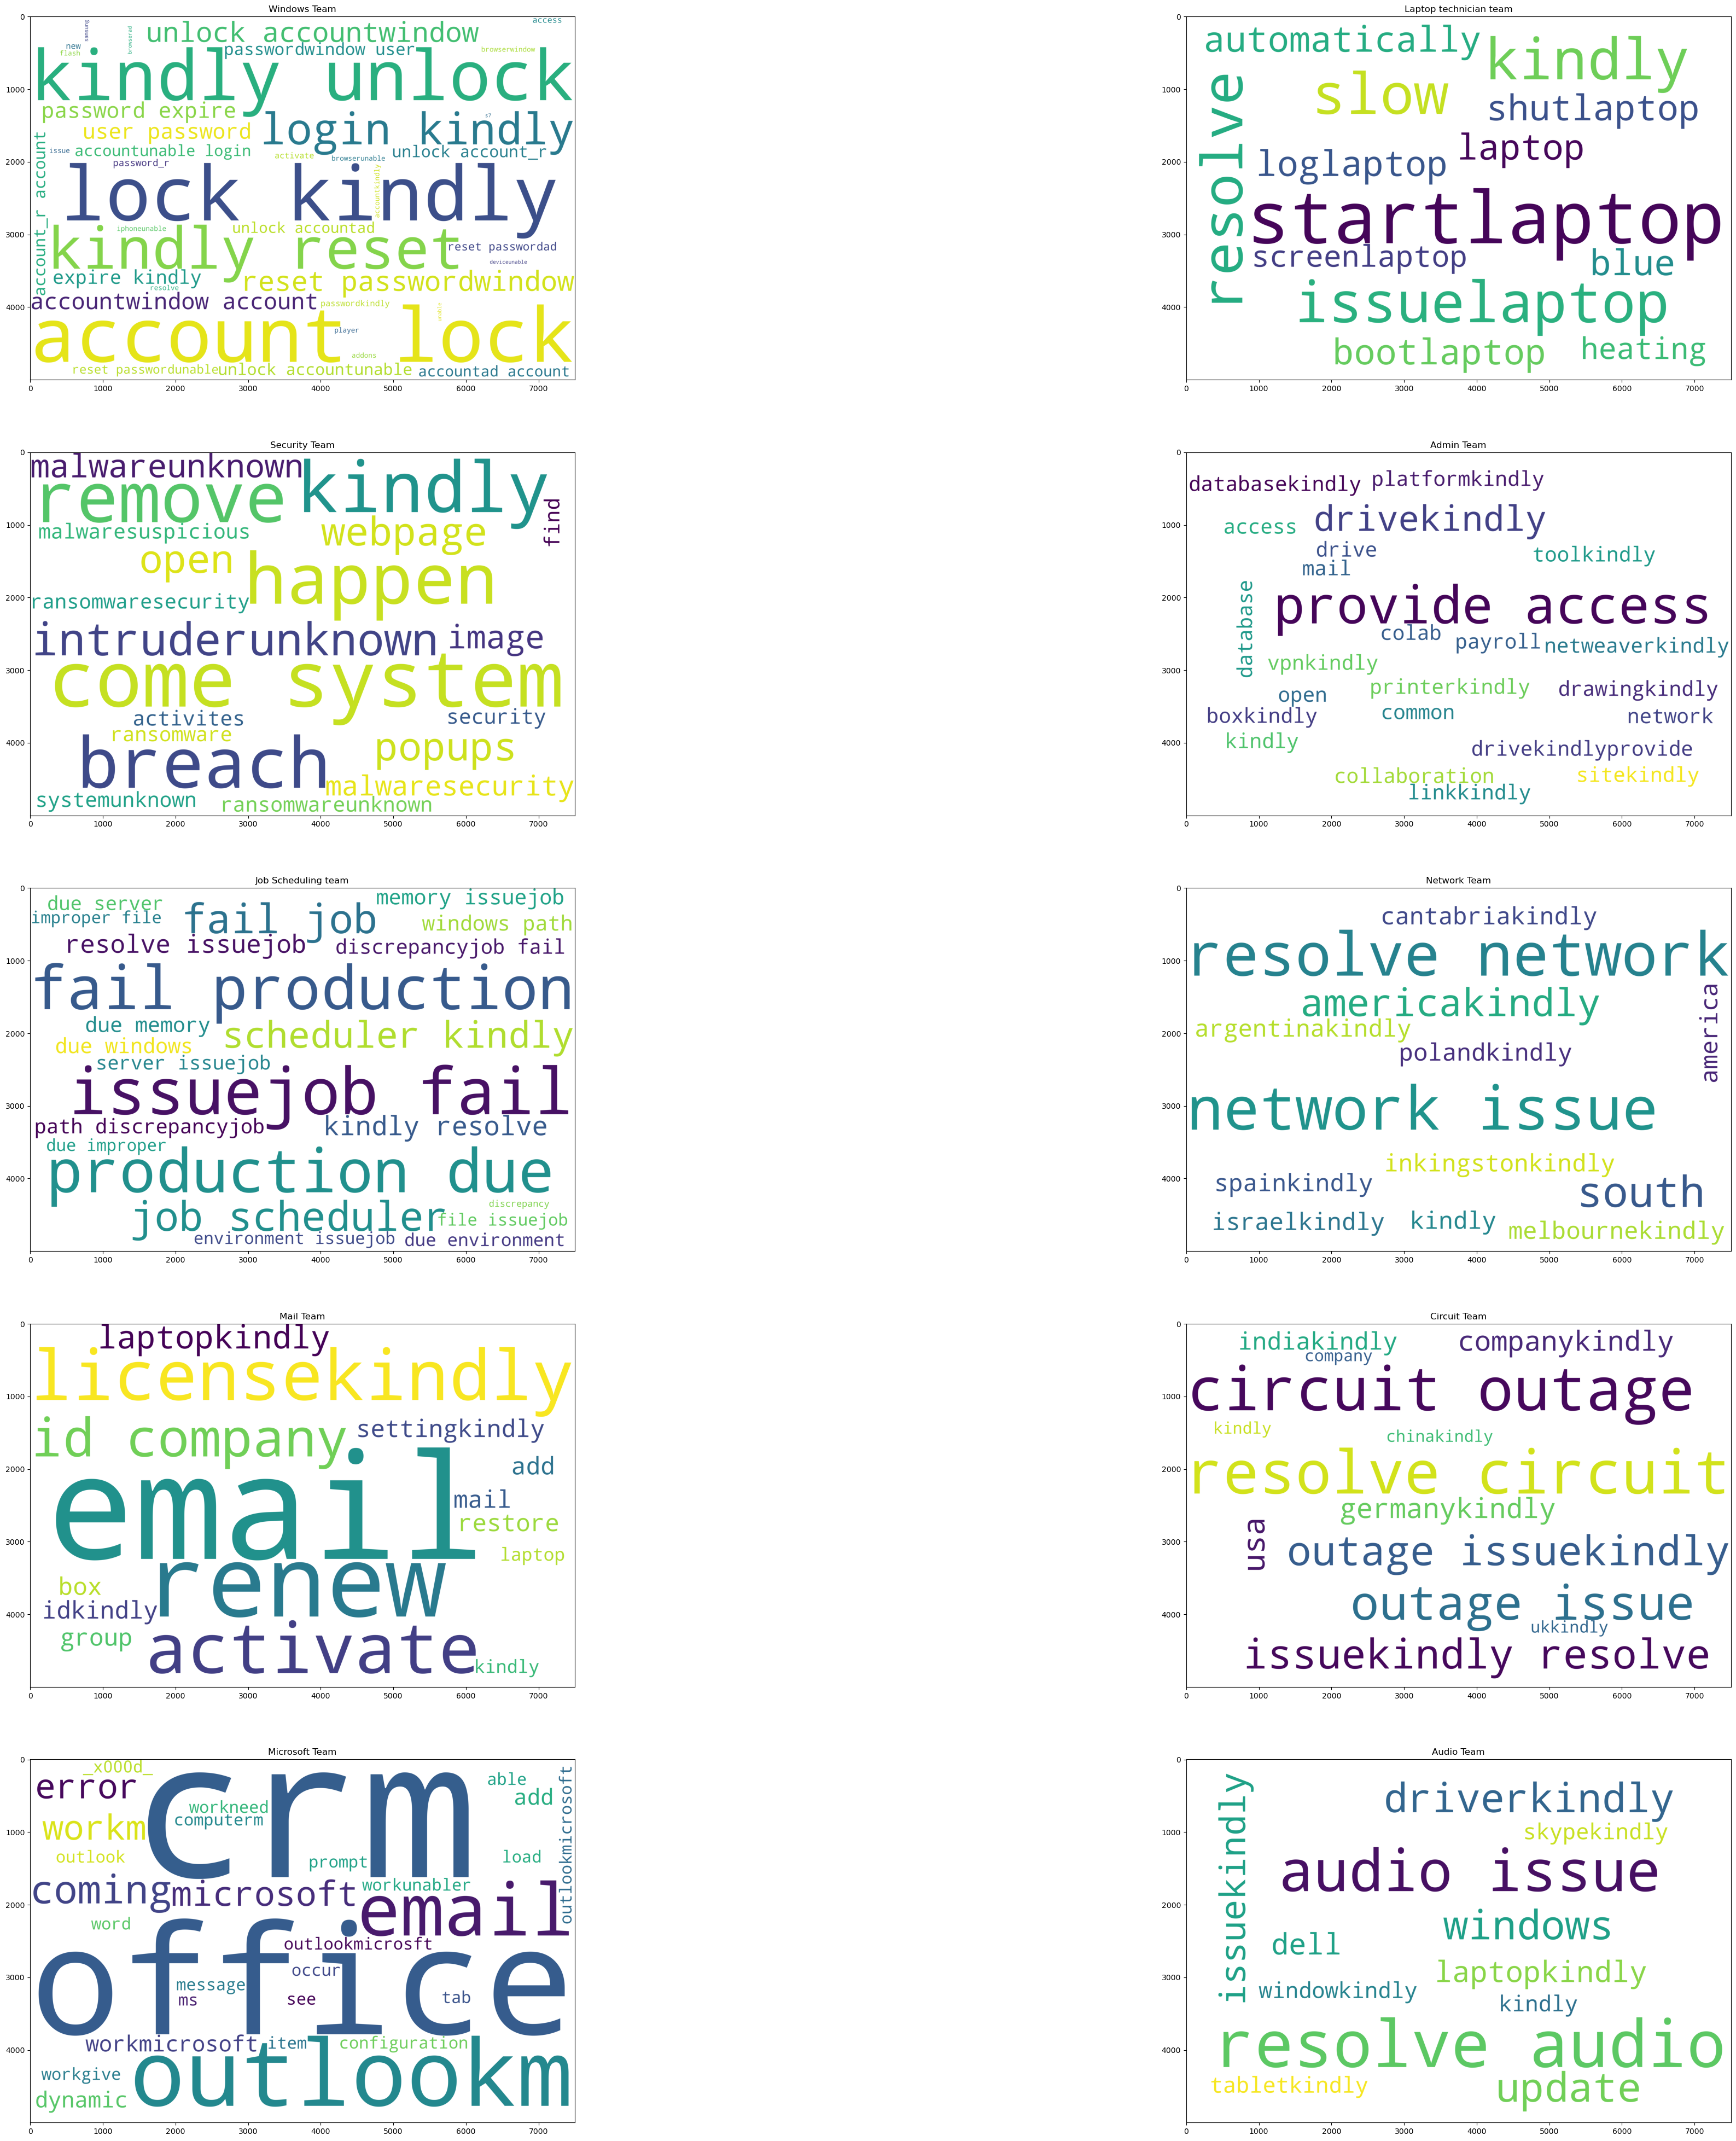

In [13]:
from wordcloud import WordCloud
wc=WordCloud(width=7500,height=5000,background_color='white')

fig = plt.figure(figsize=(50,50))
for i,col in enumerate(df['Target'].unique()):
    i+=1
    ax='ax'+str(i)
    ax = fig.add_subplot(5,2,i)
    wc = wc.generate(df[df['Target']==col]['processed_description'].str.cat(sep=''))
    ax.imshow(wc)
    ax.title.set_text(col)
    


##### Encoding Target Variables with Numbers

In [22]:
column_encode={}
for i,col in enumerate(df['Target'].unique()):
    column_encode[i]=col
def get_Val(team,columns=column_encode):
    for col_val,col_name in columns.items():
        if col_name == team:
            return col_val
df['Target']= df['Target'].map(lambda team:(get_Val(team)))
df.head()

,processed_description,Target
0,unable login kindly reset password,0
1,window account lock kindly unlock account,0
2,kindly activate login new iphone,0
3,unable login kindly reset password,0
4,laptop slow kindly resolve issue,1


In [23]:
import pickle
pickle.dump(column_encode,open('target_encode.pkl','wb'))
temp = pickle.load(open('target_encode.pkl','rb'))

#### Model Building

In [24]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [25]:
corpus=[]
for description in df['processed_description']:
    corpus.append(description)

In [26]:
unique = []
for sentence in corpus:
    for word in sentence.split(' '):
        if word not in unique:
            unique.append(word)
len(unique)

166

In [27]:
#vocabulary size
vocab_size=200

##### One hot Representation of corpus

In [28]:
onehot_repr = [one_hot(words,vocab_size) for words in corpus]


##### padding the onehot encoded values to make all description of equal length

In [29]:
sent_length=25
embeded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)

In [30]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
embeded_docs=knn.fit_transform(embeded_docs)

In [31]:
from keras.utils import to_categorical
X=np.array(embeded_docs)
y=to_categorical(df['Target'], 10)


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
embedding_vector_features=25
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 25)            5000      
                                                                 
 bidirectional (Bidirectiona  (None, 25, 256)          157696    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 331,506
Trainable params: 331,506
Non-trai

In [167]:
model.fit(X_train,y_train,batch_size=30,initial_epoch=0,epochs=100,validation_data=[X_test,y_test])

Epoch 1/100
6/6 [==============================] - 0s 49ms/step - loss: 2.6351e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2136 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 2/100
6/6 [==============================] - 0s 26ms/step - loss: 2.6013e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2124 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 2.5711e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2122 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 4/100
6/6 [==============================] - 0s 26ms/step - loss: 2.5471e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2144 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 5/100
6/6 [==============================] - 0s 27ms/step - loss: 2.5081e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2132 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 6/100
6/6 [==============================] - 0s 28ms/step - loss: 2.4821e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2

Epoch 48/100
6/6 [==============================] - 0s 27ms/step - loss: 1.6066e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2119 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 49/100
6/6 [==============================] - 0s 26ms/step - loss: 1.5919e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2128 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 50/100
6/6 [==============================] - 0s 27ms/step - loss: 1.5821e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2129 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 51/100
6/6 [==============================] - 0s 26ms/step - loss: 1.5658e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2121 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 52/100
6/6 [==============================] - 0s 26ms/step - loss: 1.5523e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2121 - val_accuracy: 0.9529 - val_f1: 0.9588
Epoch 53/100
6/6 [==============================] - 0s 26ms/step - loss: 1.5466e-04 - accuracy: 1.0000 - f1: 1.0000 - val_los

Epoch 95/100
6/6 [==============================] - 0s 26ms/step - loss: 1.1273e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2125 - val_accuracy: 0.9647 - val_f1: 0.9699
Epoch 96/100
6/6 [==============================] - 0s 26ms/step - loss: 1.1201e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2131 - val_accuracy: 0.9647 - val_f1: 0.9699
Epoch 97/100
6/6 [==============================] - 0s 26ms/step - loss: 1.1119e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2154 - val_accuracy: 0.9647 - val_f1: 0.9699
Epoch 98/100
6/6 [==============================] - 0s 26ms/step - loss: 1.1064e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2142 - val_accuracy: 0.9647 - val_f1: 0.9699
Epoch 99/100
6/6 [==============================] - 0s 26ms/step - loss: 1.0979e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2131 - val_accuracy: 0.9647 - val_f1: 0.9699
Epoch 100/100
6/6 [==============================] - 0s 26ms/step - loss: 1.0898e-04 - accuracy: 1.0000 - f1: 1.0000 - val_lo

In [162]:
predicted = model.predict(X_test)

3/3 [==============================] - 1s 12ms/step


In [163]:
predicted_labels=[np.argmax(i) for i in predicted]
expected_labels=[np.argmax(i) for i in y_test]

In [164]:
result=pd.DataFrame()
result['Expected']=expected_labels
result['Predicted']=predicted_labels
result

,Expected,Predicted
0,8,8
1,4,4
2,8,1
3,0,0
4,0,0
...,...,...
80,4,4
81,4,4
82,0,0
83,4,4


In [101]:
def custom_confusion_matrix(df: pd.DataFrame, col1: str, col2: str):

    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )

In [102]:
cm=custom_confusion_matrix(result, 'Expected','Predicted')

Text(95.72222222222221, 0.5, 'Expected')

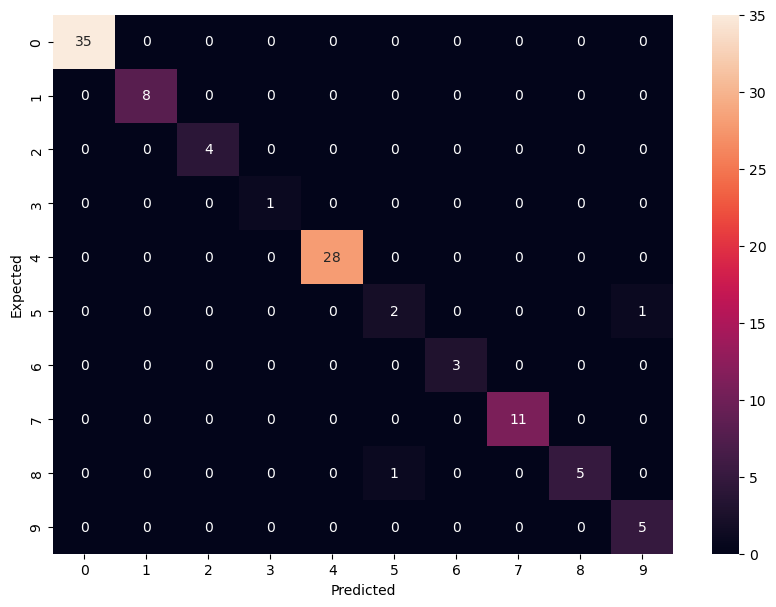

In [103]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Expected')

In [136]:
model.save('ticket_classifier_classweights.h5')

In [32]:
column_encode

{0: 'Windows Team',
 1: 'Laptop technician team',
 2: 'Security Team',
 3: 'Admin Team',
 4: 'Job Scheduling team',
 5: 'Network Team',
 6: 'Mail Team',
 7: 'Circuit Team',
 8: 'Microsoft Team',
 9: 'Audio Team'}

In [169]:
from tensorflow.keras.models import load_model
corpus = ['unable to login.Kindly reset the password']
model2 = load_model('ticket_classifier_classweights.h5',custom_objects={'f1':f1})
sent_length=25

onehot_repr=[one_hot(words,200)for words in corpus] 
embedded_docs_test= pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
prediction=model2.predict(embedded_docs_test)
predicted_labels=[np.argmax(i) for i in prediction]
predicted_labels="".join(str(x) for x in predicted_labels)
predicted_labels=int(predicted_labels)
for key,value in column_encode.items():
    if predicted_labels==key:
        print('Kindly wait for few minutes the issue is being assigned to',value)

1/1 [==============================] - 1s 1s/step
Kindly wait for few minutes the issue is being assigned to Admin Team


# Predicting Next word based on Previous Words

#### Tensorflow Tokenization(Tokenization + One hot encoding)

In [33]:
tokenizer = Tokenizer(oov_token=1)
tokenizer.fit_on_texts(list(df['processed_description']))

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences(list(df['processed_description']))

In [34]:
tokenizer.word_index

{1: 1,
 'kindly': 2,
 'issue': 3,
 'account': 4,
 'job': 5,
 'fail': 6,
 'resolve': 7,
 'production': 8,
 'due': 9,
 'lock': 10,
 'unlock': 11,
 'password': 12,
 'window': 13,
 'reset': 14,
 'unable': 15,
 'login': 16,
 'circuit': 17,
 'outage': 18,
 'laptop': 19,
 'access': 20,
 'scheduler': 21,
 'not': 22,
 'email': 23,
 'ad': 24,
 'windows': 25,
 'provide': 26,
 'audio': 27,
 'r': 28,
 'user': 29,
 'expire': 30,
 'memory': 31,
 'path': 32,
 'discrepancy': 33,
 'network': 34,
 'server': 35,
 'company': 36,
 'environment': 37,
 'improper': 38,
 'file': 39,
 'crm': 40,
 'm': 41,
 'activate': 42,
 'drive': 43,
 'outlook': 44,
 'office': 45,
 'work': 46,
 'unknown': 47,
 'start': 48,
 'id': 49,
 'microsoft': 50,
 'system': 51,
 'south': 52,
 'america': 53,
 'renew': 54,
 'license': 55,
 'browser': 56,
 'usa': 57,
 'come': 58,
 'malware': 59,
 'slow': 60,
 'security': 61,
 'breach': 62,
 'happen': 63,
 'remove': 64,
 'intruder': 65,
 'coming': 66,
 'add': 67,
 'update': 68,
 'driver': 69,

In [35]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

168


#### Creating dataset 
(Creating a sequence of 4 words)

In [36]:
x_input=[]
y_output=[]
for i_index,i_value in enumerate(sequence_data):
    for j_index in range(0,len(i_value)-3):
        x_input.append(i_value[j_index:j_index+3])
        y_output.append(i_value[j_index+3])

##### Creating DataFrame to have look on the split

In [38]:
next_word_df = pd.DataFrame(x_input,columns=['x1','x2','x3'])
next_word_df['O/p']=y_output
next_word_df.head()     

,x1,x2,x3,O/p
0,15,16,2,14
1,16,2,14,12
2,13,4,10,2
3,4,10,2,11
4,10,2,11,4


In [39]:
next_word_df.shape

(878, 4)

#### Now we are converting DF into list for further processing

In [54]:
X = next_word_df.iloc[:,:-1].values
y=next_word_df.iloc[:,-1].values


In [57]:
X

array([[15, 16,  2],
       [16,  2, 14],
       [13,  4, 10],
       ...,
       [13,  4, 10],
       [ 4, 10,  2],
       [10,  2, 11]], dtype=int64)

In [42]:
X = np.reshape(X,(X.shape[0],X.shape[1],1))
y=y

#### Train Test Split

In [33]:
#Defining Train size and test size
# training_size = int(len(next_word_df)*0.65)
# test_size = len(next_word_df)-int(len(next_word_df)*0.65)
# train_data = next_word_df[0:training_size]
# test_data = next_word_df[training_size:]

# train_data.shape ,test_data.shape

#train test split
# X_train=train_data.iloc[:,:-1]
# X_test=test_data.iloc[:,:-1]
# y_train=train_data.iloc[:,-1]
# y_test=test_data.iloc[:,-1]






#------------------------------------------------------------------------------------

# temp=X_train.values

#Explaination
#X_train.values (convert dataframe to np.array)

#Reshape input 
#np.reshape(np.array,newsize)


#Reshaping to pass it to model
# X_train = np.reshape(X_train.values,(X_train.values.shape[0],X_train.values.shape[1],1))
# X_test = np.reshape(X_test.values,(X_test.values.shape[0],X_test.values.shape[1],1))

In [43]:
X.shape ,y.shape

((878, 3, 1), (878,))

In [50]:
X.dtype='float'
y.dtype='float'

#### HyperParameter Tuning

In [82]:
def build_model(hp):
    vocab_size=168
    embedding_vector_features=hp.Choice('embedding_vector_features',[10,15,20])
    model3=Sequential()
    model3.add(Embedding(vocab_size,embedding_vector_features,input_length=3))
    model3.add(LSTM(units=hp.Int('units',min_value=10, max_value=500, step=20),
                   dropout=hp.Float('droput',min_value=0.15, max_value=0.99, step=0.05),
                   recurrent_dropout=hp.Float('redroput',min_value=0.05, max_value=0.99, step=0.05),
                   activation='relu',
                   return_sequences=True))
    model3.add(LSTM(units=hp.Int('units',min_value=10, max_value=500, step=20),
                   dropout=hp.Float('droput',min_value=0.15, max_value=0.99, step=0.05),
                   activation='relu',return_sequences=True))
    model3.add(keras.layers.LSTM(units=hp.Int('units',min_value=10, max_value=500, step=20), activation='relu'))
    model3.add(Dense(vocab_size, activation="softmax"))
    model3.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice  ('learning_rate', [1e-2, 1e-3, 1e-4])   ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model3
        

In [83]:
import keras_tuner as kt
bayesian_opt_tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=200,
    executions_per_trial=1,
    project_name='Autocompletion_POC',
    overwrite=True)


In [84]:
bayesian_opt_tuner.search(x=X ,y=y, 
             epochs=300,
             #validation_data=(xval ,xval),
             validation_split=0.2,
             validation_steps=30,  
             steps_per_epoch=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                              patience=4,
                              verbose=1,
                              restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.1, 
                                   patience= 2, 
                                   verbose=1, 
                                   min_delta=1e-5, 
                                   mode='min')]
             )

Trial 200 Complete [00h 00m 13s]
val_loss: 4.873170852661133

Best val_loss So Far: 3.44919753074646
Total elapsed time: 01h 30m 00s
INFO:tensorflow:Oracle triggered exit


In [85]:
bayesian_opt_tuner.results_summary()

Results summary
Results in .\Autocompletion_POC
Showing 10 best trials
Trial summary
Hyperparameters:
embedding_vector_features: 20
units: 490
droput: 0.15
redroput: 0.6500000000000001
learning_rate: 0.01
Score: 3.44919753074646
Trial summary
Hyperparameters:
embedding_vector_features: 20
units: 490
droput: 0.15
redroput: 0.6500000000000001
learning_rate: 0.01
Score: 3.8631627559661865
Trial summary
Hyperparameters:
embedding_vector_features: 20
units: 10
droput: 0.15
redroput: 0.05
learning_rate: 0.01
Score: 3.8679587841033936
Trial summary
Hyperparameters:
embedding_vector_features: 20
units: 490
droput: 0.25
redroput: 0.6000000000000001
learning_rate: 0.01
Score: 3.9181649684906006
Trial summary
Hyperparameters:
embedding_vector_features: 20
units: 490
droput: 0.15
redroput: 0.6500000000000001
learning_rate: 0.01
Score: 3.9760375022888184
Trial summary
Hyperparameters:
embedding_vector_features: 15
units: 270
droput: 0.7500000000000002
redroput: 0.2
learning_rate: 0.01
Score: 4.0544

##### Model Building based on HyperParameters from Keras Tuner

In [91]:
embedding_vector_features = 20
model1 = Sequential()
model1.add(Embedding(vocab_size,embedding_vector_features,input_length=3))
model1.add(LSTM(490,dropout=0.15,recurrent_dropout=0.65,return_sequences=True,weigh))
model1.add(LSTM(490,dropout=0.15,recurrent_dropout=0.65,return_sequences=True))
model1.add(LSTM(490,dropout=0.15,recurrent_dropout=0.65))
model1.add(Dense(vocab_size, activation="softmax"))

In [123]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("next_words_finalized.h5", monitor='loss', verbose=1, save_best_only=True)
model1.compile(loss="sparse_categorical_crossentropy" ,optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])
history=model1.fit(X, y, epochs=100, callbacks=[checkpoint],validation_split=0.1)

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.8132
Epoch 1: loss did not improve from 0.28780
28/28 [==============================] - 7s 61ms/step - loss: 1.0376 - accuracy: 0.8132
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.8223
Epoch 2: loss did not improve from 0.28780
28/28 [==============================] - 2s 65ms/step - loss: 0.6261 - accuracy: 0.8223
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.5291 - accuracy: 0.8565
Epoch 3: loss did not improve from 0.28780
28/28 [==============================] - 2s 61ms/step - loss: 0.5291 - accuracy: 0.8565
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.8349
Epoch 4: loss did not improve from 0.28780
28/28 [==============================] - 2s 62ms/step - loss: 0.4963 - accuracy: 0.8349
Epoch 5/100
28/28 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.8554
E

28/28 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.8462
Epoch 37: loss did not improve from 0.28780
28/28 [==============================] - 2s 63ms/step - loss: 0.4996 - accuracy: 0.8462
Epoch 38/100
28/28 [==============================] - ETA: 0s - loss: 0.4812 - accuracy: 0.8440
Epoch 38: loss did not improve from 0.28780
28/28 [==============================] - 2s 63ms/step - loss: 0.4812 - accuracy: 0.8440
Epoch 39/100
28/28 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.8554
Epoch 39: loss did not improve from 0.28780
28/28 [==============================] - 2s 61ms/step - loss: 0.4308 - accuracy: 0.8554
Epoch 40/100
28/28 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8519
Epoch 40: loss did not improve from 0.28780
28/28 [==============================] - 2s 64ms/step - loss: 0.4623 - accuracy: 0.8519
Epoch 41/100
28/28 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8474
Epoch

Epoch 73/100
28/28 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.8633
Epoch 73: loss did not improve from 0.28780
28/28 [==============================] - 2s 62ms/step - loss: 0.4487 - accuracy: 0.8633
Epoch 74/100
28/28 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8542
Epoch 74: loss did not improve from 0.28780
28/28 [==============================] - 2s 63ms/step - loss: 0.4326 - accuracy: 0.8542
Epoch 75/100
28/28 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8724
Epoch 75: loss did not improve from 0.28780
28/28 [==============================] - 2s 62ms/step - loss: 0.4212 - accuracy: 0.8724
Epoch 76/100
28/28 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8667
Epoch 76: loss did not improve from 0.28780
28/28 [==============================] - 2s 64ms/step - loss: 0.4055 - accuracy: 0.8667
Epoch 77/100
28/28 [==============================] - ETA: 0s - loss: 0.3773 - accuracy:

In [97]:
# import keras
# from matplotlib import pyplot as plt
# #history = model1.fit(X, y, epochs=100,batch_size=70, callbacks=[checkpoint],validation_split=0.2)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [98]:
# import keras
# from matplotlib import pyplot as plt
# #history = model1.fit(X, y, epochs=100,batch_size=70, callbacks=[checkpoint],validation_split=0.2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [118]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words_finalized.h5')
#model = load_model('temp.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):
    sequence = tokenizer.texts_to_sequences([text])
    preds = np.argmax(model.predict(sequence))
    predicted_word = ""
    i=0
    for key, value in tokenizer.word_index.items():
        if value == preds:
            predicted_word = key
            break
    print(predicted_word)
    return predicted_word

In [121]:
while(True):
    text = input("Enter your line: ")
    if text == "0":
        print("Execution completed.....")
        break
  
    else:
        try:
            text = text.split(" ")
            text = text[-3:]
            Predict_Next_Words(model, tokenizer, text)
          
        except Exception as e:
            print("Error occurred: ",e)
            continue

Enter your line: password expired kindly
1/1 [==============================] - 0s 43ms/step
reset
Enter your line: kindly renew email
1/1 [==============================] - 0s 46ms/step
license
Enter your line: microsoft word not
1/1 [==============================] - 0s 43ms/step
work
Enter your line: job failed kindly
1/1 [==============================] - 0s 42ms/step
resolve
Enter your line: 0
Execution completed.....
